In [204]:
import geopandas as gpd
import pandas as pd
from gerrychain import Graph
import random
import networkx as nx
import numpy as np
#from gerrychain import Graph, Partition, Election
#from gerrychain.updaters import Tally, cut_edges


# vtd['vote_difference'] = vtd.EL16G_GV_R - vtd.EL16G_GV_D
# vtd.plot("vote_difference", legend = True, figsize = (20,20) )
# vtd_county.plot("EL12G_GV_R", legend = True, figsize = (10,10) )
#vtd_county = vtd.dissolve(by='County', aggfunc='sum')
#vtd_county.to_file("./data/NC_county_merged.json", driver="GeoJSON")  

In [205]:
np.nan

nan

# Load and Process Data

In [39]:
vtd = gpd.read_file("./data/NC_VTD.shp").to_crs("EPSG:4269")
bg = gpd.read_file("./data/tl_2016_37_bg.shp").to_crs("EPSG:4269")
blocks = gpd.read_file("./data/blocks/tl_2016_37_tabblock10.shp").to_crs("EPSG:4269")

## Join VTDs and Blocks

In [40]:
#joined_within = gpd.sjoin(blocks, vtd, how = 'left', predicate = 'within' )
#joined_within[["GEOID10", "VTD"]].groupby("GEOID10").agg('count').value_counts()

i = 0 # only change to 1 to experiment with block groups;
geo_table = [ blocks, bg][i]
geo_id = ["GEOID10", "GEOID"][i]

joined = gpd.sjoin(geo_table, vtd, how = 'left',  predicate = 'intersects' )
mapping = joined[[geo_id, "VTD"]]

### Checking number of intersections:

In [41]:
display(joined[[geo_id, "VTD"]].groupby(geo_id).agg('count').value_counts())
#counts = joined[[geo_id, "VTD"]].groupby(geo_id).agg('count').rename(columns = {"VTD" : "NUM INTERSECTIONS"})
#m = joined.merge(counts, left_on = geo_id, right_index = True)
#m[m["NUM INTERSECTIONS"] <= 5].plot("NUM INTERSECTIONS", legend = True)

VTD
1      201318
2       73931
3       12086
4        1524
5         112
6          13
7           3
dtype: int64

In [59]:
temp = joined[[geo_id, "VTD"]].groupby(geo_id).agg('count').value_counts()
temp.iloc[0] / temp.sum()

0.6966334125756521

## Compute Area Ratios

In [61]:
# Intersect geos with VTDs, compute area ratios
geo_table_with_map = geo_table.merge(mapping)#.merge(vtd[["VTD", "geometry"]], suffixes = ('_block', '_vt') )
geo_with_vtd = geo_table_with_map.merge(vtd,
                                                      left_on = "VTD", right_on = "VTD",
                                                      suffixes = ('_geo', '_vtd'))

geo_geos = gpd.GeoSeries(geo_with_vtd.geometry_geo).to_crs("ESRI:103500")
geo_with_vtd['geo_intersect'] = geo_geos.intersection(gpd.GeoSeries(geo_with_vtd.geometry_vtd).to_crs("ESRI:103500"))
geo_with_vtd['geo_area'] = geo_geos.area
geo_with_vtd['intersect_area'] = gpd.GeoSeries(geo_with_vtd.geo_intersect).to_crs("ESRI:103500").area
geo_with_vtd['area_proportion'] =  geo_with_vtd['intersect_area'] / geo_with_vtd['geo_area']

In [132]:
#geo_with_vtd.head(5)

Confirming that the isspue of multiple intersections is mostly to do with small intersections. Would be good to understand it but not necessary.

In [62]:
geo_with_vtd[geo_with_vtd.area_proportion >= .2][[geo_id, "VTD"]].groupby(geo_id).agg('count').value_counts()

VTD
1      288215
2         772
dtype: int64

In [67]:
temp = geo_with_vtd[geo_with_vtd.area_proportion >= .05][[geo_id, "VTD"]].groupby(geo_id).agg('count').value_counts()
temp.iloc[0] / temp.sum()

0.9911829943907512

## Adding in block level population

In [148]:
pops = pd.read_csv('./data/us2016_block_pops.csv')
pops['block_fips'] = pops.block_fips.astype("str")
vote_fields = ["EL16G_GV_R" , "EL16G_GV_D", "TOTPOP"]
fields = ['VTD', "GEOID10", 'geometry', 'area_proportion' ] +  vote_fields
geos_simple = geo_with_vtd.rename(columns = {"geometry_geo" : "geometry" })[fields]
geo_with_pop = geos_simple.merge(pops, left_on = geo_id, right_on = 'block_fips',)

In [149]:
# VTD level sums -- doing because the VTD tot pop is generally not equal to the sum of the block pops in it
# This indicates some data level issue , probably in addition to the non exact containment issue.
# Code to check:
# merged = geo_with_pop[["TOTPOP", "VTD"]].merge(geo_with_pop[["pop2016", "VTD"]].groupby("VTD").agg(sum).reset_index(), left_on = "VTD", right_on = "VTD")
# (merged.TOTPOP / merged.pop2016).sort_values().apply(lambda x : round(x,1) ).value_counts()
# But ignoring for now.
vtds_block_pops = geo_with_pop[["pop2016", "VTD"]].groupby("VTD").agg(sum)
vtds_block_pops.columns = ["pop2016_VTD_total"]
geo_with_pop = geo_with_pop.merge(vtds_block_pops, left_on = "VTD", right_index = True)
geo_with_pop['pop_proportion'] = geo_with_pop.pop2016 /  geo_with_pop.pop2016_VTD_total

# Filter out and set to zero for the ones where the intersectiokn is too small
# NB: I did not include this step the first itme running it; TODO -- rerun.


In [150]:
#geo_with_pop.area_proportion

In [151]:
#geo_with_pop['pop_proportion']  = geo_with_pop['pop_proportion']  * (geo_with_pop.area_proportion >= .2).astype(int)

In [152]:
vote_fields = ["EL16G_GV_R" , "EL16G_GV_D", "TOTPOP"]
for field in vote_fields:
    # Eventually replace with ecological inference or something
    geo_with_pop[field + "_block"] = geo_with_pop['pop_proportion'] * geo_with_pop[field]

In [153]:
#geo_with_pop = geo_with_pop
#gpd.GeoDataFrame(geo_with_pop).plot(field + "_block", legend = True, figsize = (10,10) )

### Deduping : For each block, keep only the vote apportionment from the largest VTD.

In [154]:
gdf_dedupped = geo_with_pop.sort_values('area_proportion').drop_duplicates('GEOID10', keep='last')


In [155]:
gdf_subset.pop2016.sum() / geo_with_pop.pop2016.sum()

0.6278388760008075

Dang that was a lot of dupes


In [156]:
# sanity checking
len(gdf_subset.GEOID10.unique()) / len(geo_with_pop.GEOID10.unique())

1.0

### Save  the work so far:

In [280]:
#geo_with_pop.to_csv("geo_with_pop.csv")
#.drop(columns = ["geometry_geo", "geometry_vtd", "geo_intersect"]

In [159]:
gdf_subset = gdf_dedupped[['VTD', "GEOID10", 'geometry', "TOTPOP", "pop2016", "pop_proportion", 'area_proportion' ] +  [ x + "_block" for x in vote_fields] ]
gdf_subset = gpd.GeoDataFrame(gdf_subset)

In [121]:
test = gpd.GeoDataFrame(gdf_subset, geometry="geometry", crs= "ESRI:103500")#.head(10)
test.to_file('./processed_data_outputs/blocks_with_votes.shp')

C:\Users\lnajt\AppData\Local\Temp\ipykernel_24728\2894013665.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  test.to_file('./processed_data_outputs/export.shp')


In [295]:
test_in = gpd.read_file('./processed_data_outputs/blocks_with_votes.shp')

# Building our own VTDs 

SEe VTD properties notebook for info on properties of VTDs

### Simple metamander strategy:

Attempt here is to try to force packing, by building VTDs in the democratic leaning areas that have many adjacencies. (Triangles) and that are square like away.

Alternatively, can we make slightly larger VTDs in democratic areas?

One way to accomplish this; MCMC over 

In [127]:
gdf_subset= gpd.GeoDataFrame(gdf_subset)

<AxesSubplot: >

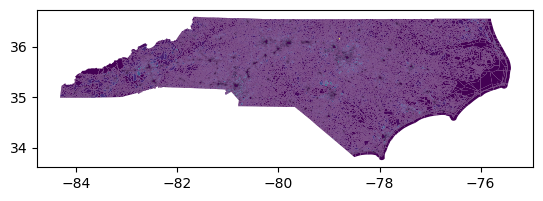

In [128]:
gdf_subset.plot("pop2016")

# Metamanering VTDs by packing

## Make Graph

In [160]:
gdf_subset['pos'] = gdf_subset.centroid

C:\Users\lnajt\AppData\Local\Temp\ipykernel_24728\522360522.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_subset['pos'] = gdf_subset.centroid


In [161]:
gdf_subset = gdf_subset.rename(columns = { "EL16G_GV_D_block" : "dem", "EL16G_GV_R_block" : "rep"})

In [164]:
gdf_subset['dem_prop'] = gdf_subset.dem / gdf_subset.TOTPOP_block
gdf_subset['rep_prop'] = gdf_subset.rep / gdf_subset.TOTPOP_block


### Saving the gdf

In [184]:
gpd.GeoDataFrame(gdf_subset.drop(columns = ["pos"]), geometry = "geometry",
                 crs= "ESRI:103500").to_file('./processed_data_outputs/blocks_df.geojson', driver='GeoJSON')  

### Making and  saving the graph

In [167]:
blocks_graph = Graph.from_geodataframe(gdf_subset, ignore_errors=True)#

C:\Users\lnajt\anaconda3\envs\gerry\lib\site-packages\gerrychain\graph\adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)
C:\Users\lnajt\anaconda3\envs\gerry\lib\site-packages\gerrychain\graph\graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
C:\Users\lnajt\anaconda3\envs\gerry\lib\site-packages\gerrychain\graph\graph.py:272: UserWarning: NA values found in column dem_prop!
  warnings.warn("NA values found in column {}!".format(column))
C:\Users\lnajt\anaconda3\envs\gerry\lib\site-packages\gerrychain\graph\graph.py:272: UserWarning: NA values found in column rep_prop!
  warnings.warn("NA values found in column {}!".format(column))


In [168]:
blocks_graph.nodes[71710]

{'boundary_node': True,
 'boundary_perim': 0.0006337105017212873,
 'area': 1.1672849999990542e-07,
 'VTD': '3716905',
 'GEOID10': '371690703002006',
 'geometry': <shapely.geometry.polygon.Polygon at 0x2abb2d6aec0>,
 'TOTPOP': 1067,
 'pop2016': 0,
 'pop_proportion': 0.0,
 'area_proportion': 0.23375256474219527,
 'rep': 0.0,
 'dem': 0.0,
 'TOTPOP_block': 0.0,
 'pos': <shapely.geometry.point.Point at 0x2ae9da2ae00>,
 'dem_prop': nan,
 'rep_prop': nan}

In [169]:
blocks_graph.to_json('./processed_data_outputs/blocks_graph.json', include_geometries_as_geojson=True)

In [176]:
blocks_graph_test = Graph.from_json('./processed_data_outputs/blocks_graph.json')

In [241]:
def agglomerate(graph, ag_field = "dem_prop", agg_field_threshold = .5,  pop_cap = 6000, steps = 1000000):
    # go through map, agglomerate VTDs that have similar EL16G_GV_D_block proportions, until pop_cap is reached
    # also allow merging of zero pop blocks with no condition.
    for i in range(steps):
        if i % 5000 == 0:
            print(i)
            edges = list(blocks_graph_test.edges())
        e = random.choice(edges)
        if graph.has_edge(e[0], e[1]):

            if  (graph.nodes[e[0]]['TOTPOP_block'] == 0 or
                 graph.nodes[e[1]]['TOTPOP_block'] == 0 or
                 (graph.nodes[e[0]][ag_field] >  agg_field_threshold and 
                graph.nodes[e[1]][ag_field] >  agg_field_threshold)):
                tot_pop = graph.nodes[e[0]]['TOTPOP_block'] + graph.nodes[e[1]]['TOTPOP_block']
                tot_dem = graph.nodes[e[0]]['dem']+ graph.nodes[e[1]]['dem']
                tot_rep = graph.nodes[e[0]]['rep'] + graph.nodes[e[1]]['rep']
                if tot_pop < pop_cap:
                        nx.contracted_nodes(graph, e[0], e[1], copy = False, self_loops = False)
                        # according to documentation node named e[0] remains
                        #print(i)
                        graph.nodes[e[0]]['TOTPOP_block'] = tot_pop
                        graph.nodes[e[0]]['dem'] = tot_dem
                        graph.nodes[e[0]]['rep'] = tot_rep
                        if tot_pop !=0 :

                            graph.nodes[e[0]]['dem_prop'] = tot_dem / tot_pop
                            graph.nodes[e[0]]['rep_prop'] = tot_rep / tot_pop
                        else:
                            graph.nodes[e[0]]['dem_prop'] = np.nan
                            graph.nodes[e[0]]['rep_prop'] = np.nan

In [ ]:
agglomerate(graph = blocks_graph_test, steps = 1000000)

1
6
9
27
30
35
51
53
57
59
63
71
75
79
99
102
140
144
147
150
152
153
162
170
180
182
188
191
208
209
211
225
234
239
242
243
246
249
251
253
259
262
275
287
295
296
298
318
330
336
341
342
346
350
352
359
361
371
381
394
405
419
444
448
456
457
463
468
469
472
491
496
513
515
522
524
525
532
536
538
539
541
550
551
553
566
567
574
576
577
592
601
607
642
644
649
651
652
653
658
665
670
673
681
687
696
702
703
715
720
726
729
735
742
745
746
756
768
771
787
793
794
798
806
809
810
811
813
816
831
836
843
845
851
860
864
870
872
878
883
896
898
901
903
908
911
914
933
934
939
946
949
956
967
969
970
979
983
987
1003
1004
1010
1020
1025
1026
1035
1042
1043
1049
1059
1062
1066
1071
1080
1086
1089
1090
1097
1104
1105
1107
1108
1111
1117
1118
1120
1126
1131
1133
1143
1144
1159
1161
1167
1169
1175
1181
1182
1203
1226
1228
1229
1240
1242
1253
1254
1255
1257
1264
1265
1266
1268
1270
1273
1278
1283
1318
1322
1331
1338
1340
1342
1354
1360
1373
1391
1399
1409
1418
1433
1434
1441
1442
1444
1445
14

10008
10013
10016
10021
10031
10035
10039
10043
10045
10053
10078
10079
10084
10085
10090
10103
10104
10105
10127
10134
10135
10142
10152
10155
10161
10167
10171
10173
10174
10177
10178
10179
10181
10183
10189
10196
10206
10212
10213
10218
10220
10223
10226
10234
10235
10236
10237
10238
10244
10245
10285
10290
10292
10294
10304
10312
10320
10325
10326
10332
10340
10352
10357
10369
10371
10374
10375
10384
10387
10397
10407
10427
10431
10432
10438
10463
10514
10536
10539
10547
10549
10552
10556
10566
10569
10573
10576
10579
10583
10589
10591
10593
10595
10596
10598
10622
10625
10640
10642
10643
10646
10648
10661
10662
10669
10682
10697
10703
10704
10716
10722
10723
10751
10759
10762
10764
10768
10775
10781
10786
10787
10790
10791
10793
10797
10802
10810
10811
10813
10819
10829
10834
10845
10846
10852
10853
10856
10860
10864
10877
10878
10880
10883
10888
10893
10897
10903
10908
10911
10913
10923
10929
10932
10936
10937
10948
10953
10956
10965
10968
10973
10984
10992
10995
10996
10997
1102

20001
20015
20021
20022
20032
20034
20035
20057
20070
20075
20087
20090
20098
20099
20103
20130
20132
20141
20144
20147
20152
20161
20166
20175
20180
20181
20188
20196
20207
20212
20213
20215
20222
20227
20229
20237
20243
20245
20246
20287
20302
20304
20309
20317
20326
20328
20336
20337
20353
20375
20377
20379
20397
20398
20422
20429
20431
20432
20433
20435
20446
20452
20453
20465
20480
20488
20497
20501
20505
20522
20527
20533
20544
20559
20565
20571
20601
20604
20606
20614
20620
20623
20632
20641
20647
20650
20659
20673
20687
20689
20704
20709
20722
20727
20729
20733
20746
20750
20752
20757
20764
20782
20786
20801
20802
20810
20838
20843
20853
20873
20884
20891
20902
20911
20913
20918
20926
20939
20940
20942
20945
20949
20951
20955
20956
20963
20970
20982
20983
20989
21002
21005
21007
21010
21017
21026
21042
21049
21052
21053
21056
21057
21070
21077
21081
21083
21100
21101
21105
21107
21115
21137
21140
21154
21155
21157
21158
21160
21162
21182
21183
21184
21207
21209
21218
21221
2123

30000
30004
30020
30037
30039
30056
30057
30064
30066
30070
30076
30094
30098
30108
30117
30119
30120
30127
30129
30131
30133
30153
30165
30171
30178
30186
30190
30191
30218
30219
30220
30223
30229
30232
30241
30246
30259
30272
30293
30295
30326
30344
30349
30359
30361
30365
30372
30385
30386
30391
30401
30414
30430
30434
30442
30472
30486
30491
30524
30526
30534
30537
30539
30548
30552
30559
30561
30562
30565
30572
30573
30576
30580
30587
30589
30592
30593
30608
30615
30622
30625
30634
30638
30639
30650
30652
30661
30667
30671
30672
30676
30681
30694
30704
30707
30732
30733
30736
30739
30750
30756
30757
30775
30776
30784
30791
30793
30794
30795
30807
30821
30825
30832
30835
30839
30843
30847
30853
30857
30869
30873
30878
30882
30883
30884
30891
30897
30918
30933
30939
30944
30949
30962
30971
30973
30975
30976
30981
30997
30998
31009
31010
31027
31033
31054
31055
31058
31061
31067
31083
31089
31097
31122
31133
31141
31146
31149
31151
31159
31170
31180
31181
31185
31189
31190
31191
3119

40011
40017
40018
40029
40033
40045
40063
40067
40073
40089
40096
40105
40107
40115
40116
40117
40121
40125
40129
40136
40137
40149
40154
40157
40176
40180
40181
40186
40187
40190
40191
40199
40203
40205
40213
40223
40225
40232
40237
40243
40246
40258
40264
40272
40273
40276
40281
40283
40286
40292
40294
40295
40308
40309
40312
40318
40323
40333
40335
40336
40337
40349
40353
40354
40401
40409
40410
40418
40425
40427
40440
40441
40442
40444
40445
40447
40448
40457
40460
40461
40465
40471
40483
40489
40495
40502
40506
40510
40516
40533
40534
40540
40543
40544
40551
40555
40560
40573
40579
40580
40582
40584
40585
40587
40598
40610
40618
40620
40625
40628
40639
40644
40656
40663
40668
40682
40694
40696
40733
40738
40739
40742
40746
40756
40758
40759
40761
40762
40771
40774
40778
40785
40790
40797
40812
40818
40825
40826
40827
40840
40842
40849
40853
40858
40867
40882
40889
40890
40894
40896
40918
40921
40932
40935
40940
40946
40948
40970
40976
40980
40996
41001
41006
41013
41014
41020
4102

50012
50014
50015
50020
50024
50037
50038
50044
50068
50078
50084
50111
50118
50125
50129
50144
50151
50158
50177
50180
50184
50189
50213
50225
50229
50254
50256
50258
50270
50274
50275
50293
50311
50329
50330
50334
50340
50342
50364
50367
50368
50375
50376
50377
50389
50397
50399
50405
50408
50432
50433
50435
50440
50450
50459
50460
50474
50475
50478
50480
50485
50487
50497
50509
50524
50528
50535
50536
50539
50540
50543
50544
50551
50563
50565
50578
50593
50597
50604
50607
50612
50614
50615
50616
50620
50622
50627
50628
50629
50634
50648
50650
50652
50657
50673
50676
50682
50683
50686
50687
50695
50696
50706
50707
50710
50714
50715
50720
50722
50724
50729
50748
50764
50770
50777
50792
50796
50799
50802
50818
50821
50836
50839
50870
50881
50885
50886
50889
50892
50893
50895
50896
50928
50935
50940
50943
50960
50963
50974
50980
50983
50991
51000
51003
51010
51017
51019
51021
51022
51024
51027
51029
51030
51032
51040
51044
51049
51055
51058
51067
51070
51072
51086
51091
51095
51098
5110

60010
60011
60021
60026
60027
60031
60052
60057
60058
60059
60071
60075
60107
60116
60142
60153
60160
60170
60171
60219
60232
60244
60256
60267
60272
60274
60276
60278
60297
60310
60324
60328
60365
60368
60371
60388
60389
60391
60394
60397
60402
60404
60406
60411
60415
60418
60439
60448
60472
60498
60520
60525
60528
60541
60546
60568
60571
60582
60583
60593
60603
60611
60617
60621
60627
60629
60633
60635
60651
60664
60666
60672
60674
60676
60689
60693
60703
60707
60709
60726
60727
60728
60734
60740
60744
60755
60759
60774
60787
60793
60799
60811
60817
60824
60839
60841
60844
60859
60881
60884
60906
60917
60919
60921
60936
60939
60940
60948
60956
60958
60959
60960
60962
60966
60970
60996
61014
61030
61035
61041
61047
61048
61052
61059
61060
61063
61073
61079
61093
61095
61107
61108
61113
61150
61152
61159
61165
61169
61174
61177
61180
61185
61190
61193
61206
61214
61219
61223
61224
61225
61244
61245
61250
61253
61258
61272
61273
61274
61276
61286
61295
61298
61307
61315
61321
61328
6133

75003
75004
75007
75017
75031
75036
75042
75054
75079
75083
75092
75108
75120
75128
75143
75145
75153
75155
75158
75162
75164
75169
75177
75196
75198
75212
75219
75222
75223
75225
75229
75251
75252
75260
75275
75282
75285
75300
75307
75316
75327
75334
75341
75381
75383
75389
75391
75396
75400
75401
75402
75419
75423
75431
75433
75458
75464
75466
75477
75508
75523
75530
75531
75534
75542
75548
75560
75563
75576
75588
75595
75598
75612
75617
75629
75649
75655
75663
75679
75684
75715
75729
75745
75757
75766
75781
75795
75808
75821
75855
75860
75863
75887
75889
75894
75896
75904
75927
75928
75929
75949
75952
75966
75972
75985
75998
76002
76013
76023
76027
76056
76058
76061
76070
76081
76085
76089
76092
76116
76143
76162
76190
76195
76203
76234
76249
76262
76263
76267
76284
76285
76291
76301
76311
76317
76318
76321
76328
76333
76335
76336
76341
76346
76367
76370
76373
76383
76390
76405
76409
76412
76416
76417
76420
76437
76453
76456
76458
76476
76481
76485
76493
76501
76521
76534
76535
7655

90004
90005
90008
90012
90014
90022
90024
90028
90029
90033
90035
90038
90048
90055
90059
90067
90080
90096
90103
90109
90130
90133
90138
90140
90141
90144
90157
90173
90185
90200
90201
90202
90204
90205
90209
90215
90217
90220
90229
90241
90243
90251
90273
90275
90290
90292
90301
90354
90373
90377
90387
90404
90405
90410
90424
90431
90432
90451
90454
90456
90457
90459
90467
90474
90482
90491
90533
90558
90570
90578
90580
90587
90613
90617
90622
90633
90649
90651
90652
90659
90664
90672
90696
90708
90725
90743
90744
90756
90758
90781
90787
90794
90804
90812
90817
90819
90835
90850
90872
90895
90917
90924
90927
90937
90941
90961
90968
90969
90979
91006
91011
91031
91036
91046
91049
91065
91067
91077
91088
91100
91107
91132
91140
91161
91185
91200
91205
91226
91229
91242
91243
91252
91272
91273
91279
91281
91282
91291
91297
91311
91312
91318
91323
91332
91344
91369
91375
91376
91388
91407
91415
91416
91421
91424
91428
91431
91439
91442
91447
91459
91465
91479
91494
91513
91521
91528
9155

105001
105012
105013
105017
105022
105051
105054
105055
105063
105080
105084
105088
105094
105111
105113
105122
105126
105127
105151
105157
105170
105171
105178
105191
105194
105201
105213
105235
105238
105244
105256
105268
105281
105290
105291
105292
105314
105318
105321
105328
105333
105353
105358
105363
105385
105389
105394
105395
105397
105411
105416
105431
105436
105439
105440
105466
105475
105478
105484
105487
105503
105512
105544
105545
105546
105548
105552
105558
105560
105566
105591
105603
105618
105623
105633
105636
105643
105646
105649
105651
105654
105664
105673
105674
105678
105693
105703
105712
105728
105747
105749
105751
105754
105768
105783
105791
105803
105809
105827
105828
105833
105839
105856
105859
105861
105868
105870
105873
105876
105879
105885
105910
105921
105928
105937
105953
105969
105995
106008
106011
106023
106030
106032
106057
106064
106074
106075
106102
106107
106137
106142
106151
106162
106187
106189
106198
106200
106223
106231
106291
106293
106305
106317

120001
120017
120032
120050
120053
120085
120088
120089
120093
120125
120132
120141
120146
120147
120154
120160
120163
120169
120202
120207
120209
120220
120258
120269
120273
120280
120292
120294
120306
120311
120317
120338
120348
120359
120364
120366
120394
120401
120402
120409
120414
120432
120433
120463
120464
120470
120473
120508
120512
120521
120538
120580
120582
120588
120594
120596
120616
120618
120621
120630
120634
120639
120648
120668
120669
120700
120718
120727
120732
120748
120752
120797
120813
120819
120832
120839
120844
120845
120849
120858
120863
120867
120875
120881
120889
120892
120898
120914
120926
120929
120953
120957
120963
120989
120994
121030
121033
121038
121054
121067
121068
121074
121077
121082
121083
121093
121095
121104
121108
121131
121137
121143
121146
121149
121150
121153
121169
121193
121203
121208
121209
121215
121220
121226
121231
121238
121240
121246
121256
121290
121310
121322
121325
121352
121353
121358
121363
121371
121385
121394
121399
121409
121412

135003
135016
135031
135032
135043
135051
135084
135091
135093
135111
135120
135135
135138
135148
135151
135155
135163
135183
135190
135195
135234
135266
135282
135288
135295
135341
135363
135373
135388
135393
135403
135465
135481
135495
135496
135497
135507
135535
135536
135537
135550
135553
135554
135559
135562
135563
135564
135566
135576
135596
135614
135617
135621
135624
135629
135643
135645
135648
135651
135668
135675
135687
135691
135694
135718
135734
135762
135787
135794
135795
135799
135809
135825
135839
135840
135841
135852
135860
135863
135867
135869
135877
135887
135888
135893
135896
135917
135920
135921
135942
135960
135963
135964
135993
135995
135998
135999
136012
136013
136024
136038
136052
136060
136075
136080
136082
136087
136114
136118
136122
136135
136141
136153
136155
136160
136170
136174
136200
136201
136214
136231
136236
136241
136245
136265
136307
136317
136319
136324
136333
136334
136335
136336
136350
136374
136375
136377
136401
136405
136409
136425
136430
136437

150000
150003
150004
150010
150023
150039
150045
150048
150079
150086
150089
150113
150114
150118
150130
150131
150144
150176
150202
150203
150205
150206
150207
150234
150239
150271
150272
150292
150307
150345
150356
150359
150362
150373
150376
150387
150390
150444
150454
150466
150469
150472
150504
150509
150526
150540
150560
150572
150577
150599
150600
150605
150607
150609
150627
150633
150650
150657
150663
150672
150708
150713
150716
150720
150722
150736
150737
150751
150753
150757
150788
150817
150820
150829
150843
150862
150875
150878
150888
150901
150920
150922
150924
150925
150931
150975
150981
150988
151006
151049
151056
151081
151100
151103
151105
151111
151123
151136
151167
151199
151223
151224
151228
151233
151235
151236
151247
151249
151254
151277
151295
151339
151353
151355
151359
151366
151368
151389
151396
151401
151418
151435
151449
151459
151490
151502
151505
151519
151529
151531
151533
151549
151554
151579
151586
151588
151596
151616
151621
151636
151644
151648
151661

165024
165029
165050
165059
165081
165084
165091
165096
165114
165124
165138
165141
165152
165153
165173
165207
165216
165217
165249
165257
165266
165282
165302
165305
165307
165313
165325
165327
165342
165370
165401
165402
165411
165414
165428
165439
165450
165452
165454
165461
165469
165503
165509
165517
165529
165576
165619
165641
165648
165655
165658
165662
165666
165684
165692
165700
165703
165714
165718
165719
165729
165732
165740
165741
165742
165746
165761
165768
165782
165795
165814
165819
165820
165862
165878
165880
165883
165893
165911
165914
165921
165953
165955
165961
165971
165973
165975
165985
165987
165993
166000
166005
166021
166036
166040
166047
166068
166088
166101
166138
166150
166168
166171
166182
166191
166212
166254
166263
166292
166310
166311
166322
166326
166328
166331
166336
166349
166363
166370
166387
166402
166403
166413
166439
166442
166446
166454
166456
166457
166465
166467
166482
166489
166500
166505
166507
166535
166547
166556
166560
166561
166562
166563

185004
185011
185019
185032
185035
185044
185063
185065
185075
185088
185102
185123
185125
185144
185157
185183
185194
185197
185222
185235
185264
185271
185287
185288
185309
185313
185320
185345
185352
185364
185370
185402
185410
185414
185421
185436
185438
185470
185476
185488
185503
185510
185517
185532
185546
185550
185552
185554
185555
185566
185583
185623
185631
185674
185682
185706
185707
185716
185774
185777
185780
185813
185838
185861
185873
185907
185921
185925
185928
185948
185961
185973
185977
186000
186006
186007
186012
186028
186043
186051
186072
186078
186084
186096
186105
186111
186144
186166
186195
186200
186201
186248
186258
186262
186291
186312
186347
186355
186387
186388
186411
186418
186423
186429
186434
186447
186454
186464
186484
186490
186497
186499
186509
186520
186523
186537
186545
186582
186585
186593
186600
186623
186632
186654
186658
186698
186724
186725
186746
186772
186786
186806
186839
186878
186929
186944
186956
186958
186961
186970
187005
187008
187009

205002
205019
205029
205039
205056
205076
205148
205262
205281
205282
205300
205325
205336
205346
205356
205368
205395
205417
205441
205442
205452
205465
205472
205489
205492
205522
205527
205543
205544
205554
205556
205557
205563
205586
205613
205617
205625
205651
205654
205659
205703
205705
205735
205741
205772
205774
205778
205806
205811
205813
205820
205821
205875
205883
205907
205924
205925
205934
205937
205969
205978
205986
205993
206001
206019
206054
206060
206080
206086
206116
206122
206146
206150
206152
206162
206172
206189
206201
206218
206244
206271
206305
206320
206323
206325
206342
206360
206432
206485
206486
206523
206538
206555
206573
206591
206609
206624
206641
206672
206673
206683
206714
206716
206740
206745
206752
206776
206810
206813
206843
206871
206881
206905
206914
206915
206924
206929
206936
206941
206960
207002
207009
207038
207039
207040
207061
207072
207082
207101
207137
207155
207176
207190
207219
207220
207230
207251
207281
207292
207297
207315
207323
207403

225031
225032
225052
225118
225126
225128
225158
225178
225183
225194
225195
225216
225236
225238
225241
225246
225260
225261
225282
225299
225301
225313
225315
225334
225336
225344
225357
225363
225366
225437
225446
225479
225487
225501
225522
225603
225623
225669
225695
225700
225702
225707
225713
225734
225736
225744
225746
225785
225812
225825
225826
225833
225835
225843
225870
225876
225878
225883
225887
225895
225897
225930
225931
225985
226006
226045
226078
226134
226141
226171
226190
226234
226235
226254
226270
226295
226313
226321
226328
226343
226374
226391
226432
226435
226535
226557
226566
226579
226588
226607
226609
226628
226633
226650
226652
226687
226690
226694
226741
226780
226784
226789
226829
226848
226856
226905
226941
226952
226961
226971
227017
227025
227084
227093
227099
227119
227120
227122
227137
227139
227146
227204
227218
227233
227235
227239
227244
227256
227279
227306
227345
227356
227367
227376
227407
227409
227410
227415
227427
227432
227446
227450
227473

250010
250023
250040
250047
250068
250103
250138
250145
250148
250157
250192
250242
250246
250273
250388
250436
250438
250452
250459
250471
250482
250486
250509
250519
250526
250532
250562
250568
250571
250584
250592
250638
250678
250742
250773
250774
250776
250777
250793
250795
250823
250850
250867
250882
250891
250922
250924
250930
250940
250952
250966
250992
251002
251034
251074
251097
251150
251203
251224
251234
251237
251243
251250
251251
251256
251266
251269
251280
251301
251309
251326
251360
251419
251440
251447
251453
251455
251465
251468
251471
251477
251489
251544
251553
251557
251576
251587
251616
251618
251642
251660
251683
251692
251693
251698
251714
251729
251736
251770
251774
251788
251811
251832
251865
251868
251934
251968
251974
251990
252003
252010
252079
252114
252187
252218
252226
252229
252250
252252
252256
252259
252261
252270
252292
252293
252296
252320
252342
252353
252359
252384
252397
252398
252403
252412
252416
252417
252427
252434
252445
252452
252486
252492

275029
275055
275068
275088
275093
275150
275155
275166
275178
275204
275242
275249
275268
275324
275366
275376
275445
275509
275547
275549
275561
275567
275609
275684
275691
275694
275695
275757
275777
275823
275841
275845
275846
275848
275895
275941
276023
276046
276065
276109
276111
276132
276166
276185
276207
276246
276265
276354
276361
276366
276411
276423
276436
276444
276459
276480
276484
276493
276501
276533
276535
276569
276612
276623
276625
276630
276660
276671
276720
276774
276775
276786
276876
276888
276889
276900
276912
276921
276930
276936
276937
276969
276990
277015
277035
277036
277059
277087
277107
277131
277138
277176
277229
277233
277259
277299
277308
277311
277322
277327
277330
277331
277342
277351
277355
277375
277380
277398
277406
277432
277464
277497
277521
277541
277562
277604
277651
277682
277709
277763
277805
277807
277809
277851
277855
277870
277874
277876
277900
277902
277944
277965
278004
278060
278066
278079
278120
278125
278143
278146
278154
278176
278231

305014
305024
305054
305060
305072
305085
305093
305158
305165
305166
305177
305219
305247
305278
305297
305326
305374
305402
305411
305423
305493
305509
305531
305532
305578
305601
305610
305641
305658
305712
305714
305722
305734
305750
305777
305779
305791
305818
305895
305986
306012
306087
306137
306180
306230
306251
306271
306314
306389
306428
306432
306444
306457
306458
306475
306548
306560
306611
306654
306679
306736
306751
306773
306802
306806
306811
306851
306871
306894
306896
306951
306967
306979
306991
307078
307079
307083
307107
307122
307140
307251
307262
307267
307284
307295
307312
307319
307346
307348
307382
307394
307408
307451
307458
307512
307543
307546
307548
307623
307665
307688
307786
307804
307819
307827
307858
307929
308012
308036
308067
308149
308180
308192
308199
308305
308323
308337
308377
308533
308546
308567
308603
308612
308619
308620
308643
308694
308696
308714
308750
308783
308793
308801
308826
308838
308870
308889
308924
308956
308977
308991
308997
309041

340007
340022
340096
340147
340182
340210
340257
340266
340352
340355
340361
340386
340400
340407
340410
340416
340418
340434
340447
340464
340465
340479
340482
340499
340536
340564
340586
340603
340704
340724
340738
340746
340749
340753
340781
340796
340861
340897
340901
340924
341011
341032
341163
341166
341193
341217
341228
341287
341335
341398
341425
341468
341510
341549
341553
341556
341558
341575
341583
341638
341646
341670
341675
341748
341759
341883
341929
341935
341955
341957
342024
342040
342043
342058
342120
342161
342230
342263
342316
342325
342335
342397
342505
342615
342640
342676
342677
342787
342799
342829
342858
342890
342991
343006
343052
343136
343141
343142
343154
343155
343213
343230
343254
343272
343323
343355
343466
343477
343490
343529
343553
343638
343657
343661
343670
343678
343709
343714
343716
343746
343783
343823
343827
343836
343837
343851
343870
343951
343995
344013
344041
344060
344127
344194
344227
344231
344319
344323
344340
344348
344350
344399
344439

In [ ]:
len(blocks_graph_test) / len(blocks_graph)


agglomerate(dem, 6000)
agglomerate(rep, 2000)
end up with bigger dem regions, VTD has caused packing

In [ ]:
# def agglomerate_faster(graph, ag_field = "dem_prop", agg_field_threshold = .5,  pop_cap = 6000, steps = 1000000):
#     # go through map, agglomerate VTDs that have similar EL16G_GV_D_block proportions, until pop_cap is reached
#     # also allow merging of zero pop blocks with no condition.
#     for e in graph.edges():
        
#         graph.edges[e]["TOTPOP"] = graph.nodes[e[0]]['TOTPOP_block'] + graph.nodes[e[1]]['TOTPOP_block']
#         graph.edges[e]["dem"]  = graph.nodes[e[0]]['dem']+ graph.nodes[e[1]]['dem']
#         graph.edges[e]["rep"]  = graph.nodes[e[0]]['rep'] + graph.nodes[e[1]]['rep']
#         graph.edges[e]["dem_prop"] = graph.edges[e]["dem"] / graph.edges[e]["TOTPOP"] 
#         graph.edges[e]["rep_prop"] = graph.edges[e]["rep"] / graph.edges[e]["TOTPOP"] 
        
#         if  (graph.nodes[e[0]]['TOTPOP_block'] == 0 or
#              graph.nodes[e[1]]['TOTPOP_block'] == 0 or
#              (graph.nodes[e[0]][ag_field] >  agg_field_threshold and 
#             graph.nodes[e[1]][ag_field] >  agg_field_threshold)):
#             tot_pop = graph.nodes[e[0]]['TOTPOP_block'] + graph.nodes[e[1]]['TOTPOP_block']
#             tot_dem = graph.nodes[e[0]]['dem']+ graph.nodes[e[1]]['dem']
#             tot_rep = graph.nodes[e[0]]['rep'] + graph.nodes[e[1]]['rep']
#             if tot_pop < pop_cap:
#                 print("contract")
#                 for x in ['dem_prop', "rep_prop", "TOTPOP_block", "rep", "dem"]:
#                     print("0 has ", x, " as ", blocks_graph.nodes[e[0]][x])
#                     print("1 has ", x, " as ", blocks_graph.nodes[e[1]][x])
#                 nx.contracted_nodes(graph, e[0], e[1], copy = False, self_loops = False)
#                 # according to documentation node named e[0] remains

#                 graph.nodes[e[0]]['TOTPOP_block'] = tot_pop
#                 graph.nodes[e[0]]['dem'] = tot_dem
#                 graph.nodes[e[0]]['rep'] = tot_rep
#                 if tot_pop !=0 :
                    
#                     graph.nodes[e[0]]['dem_prop'] = tot_dem / tot_pop
#                     graph.nodes[e[0]]['rep_prop'] = tot_rep / tot_pop
#                 else:
#                     graph.nodes[e[0]]['dem_prop'] = np.nan
#                     graph.nodes[e[0]]['rep_prop'] = np.nan

In [228]:
edge_list = nx.to_pandas_edgelist(blocks_graph_test)


KeyboardInterrupt

